# 다중 분류(다중 로지스틱 회귀 모델)
* 분류하려는 그룹이 두 개가 아닌 세 개 이상
* 회귀모델, 이진분류와 달리 분류하려는 그룹의 개수가 N개일 때, "N차원" 출력
* 내부 구조의 차이가 중요함
* 시그모이드대신 소프트맥스 함수 사용

In [1]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torchinfo import summary
from torchviz import make_dot

In [2]:
iris = load_iris()

#입력 데이터와 정답 데이터
x_org, y_org = iris.data, iris.target

#입력 데이터로 sepal(꽃받침)length(0)와 petal(꽃잎)length(2)를 추출
x_select = x_org[:, [0, 2]]#1열과 3열 선택 이유 --> 산포도 출력 시 분류하기 쉬워보여서

print('원본 데이터', x_select.shape, y_org.shape)

원본 데이터 (150, 2) (150,)


In [3]:
x_train, x_test, y_train, y_test = train_test_split(x_select, y_org, test_size=75, random_state=123)#test_size=75 --> 책과 같은 결과를 위해 조건 맞춤

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(75, 2) (75, 2) (75,) (75,)


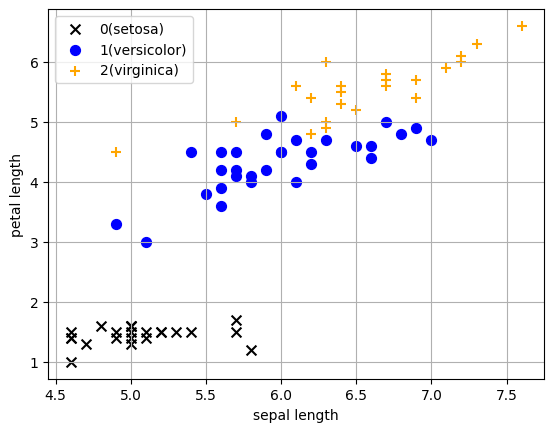

'\nsepal length와 petal length를 사용하면\n어느정도까지는 그룹으로 나눌 수 있을 것으로 보여진다\n'

In [4]:
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]
plt.scatter(x_t0[:, 0], x_t0[:, 1], marker='x', c='k', s=50, label = '0(setosa)')
plt.scatter(x_t1[:, 0], x_t1[:, 1], marker='o', c='b', s=50, label = '1(versicolor)')
plt.scatter(x_t2[:, 0], x_t2[:, 1], marker='+', c='orange', s=50, label = '2(virginica)')
plt.xlabel('sepal length')
plt.ylabel('petal length')
plt.grid()
plt.legend()
plt.show()

"""
sepal length와 petal length를 사용하면
어느정도까지는 그룹으로 나눌 수 있을 것으로 보여진다
"""

In [5]:
n_input = x_train.shape[1]

#분류 클래스 수(출력 차원 수)
n_output = len(list(set(y_train)))

print(f'입력 차원 수: {n_input}  출력 차원 수: {n_output}')

입력 차원 수: 2  출력 차원 수: 3


In [6]:
#모델 정의
class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()

        self.l1 = nn.Linear(n_input, n_output)

        #초기값 == 1
        #책과 결과를 맞추기 위해
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)

        return x1

In [7]:
net = Net(n_input, n_output)

In [8]:
for param in net.named_parameters():
    print(param)

('l1.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([1., 1., 1.], requires_grad=True))


In [9]:
criterion = nn.CrossEntropyLoss()
"""
CrossEntropyLoss(): 소프트맥스 함수 + 로그 함수 + 정답 요소 추출까지 한 번에 처리
따라서 예측함수를 정의할 때 활성화함수 없이 nn.Linear만 사용한 것
"""
lr = 0.01

optimizer = optim.SGD(net.parameters(), lr = lr)

In [10]:
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()
"""
다중분류에서 손실함수의 두 번째 인수로 사용되는 정답데이터는 정수로 입력되어야함
"""

'\n다중분류에서 손실함수의 두 번째 인수로 사용되는 정답데이터는 정수로 입력되어야함\n'

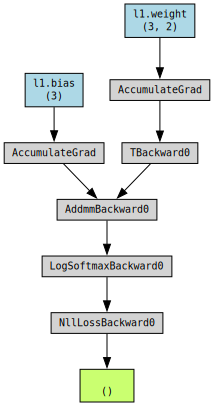

In [11]:
outputs = net(inputs)

loss = criterion(outputs, labels)

g = make_dot(loss, params= dict(net.named_parameters()))
display(g)

## 예측 라벨을 얻는 방법
> 원래라면 함수의 출력값인 확률 값 중, 가장 큰 값을 출력한 분류기를 예측 값으로 사용하는 것이 올바른 라벨의 계산 방법임


> 그러나 이번 모델은 소프트 맥스 함수를 적용하기 전 상태의 벡터임, 이 소프트맥스 함수는 입력 단계에서 최대였던 항목이 출력 이후에도 최대가 되는 성질을 가짐, 그러므로 소프트 맥스 함수 전 상태에서 최대값을 갖는 항목이 발견되면 그것이 예측 라벨이 되는 것임

In [12]:
#torch.max 함수 호출
#2번째 인수는 축을 의미함, 1이면 행별로 집계
print(torch.max(outputs, 1)) #행별로 최대값을 집계
"""
torch.max함수는 최대값 그 자체(values)와 그에 상응하는 인덱스(indices) 두 가지 정보를 동시에 반환
따라서 라벨을 얻고싶은 경우에는 두 번째, 즉 indices만 취하면 됨
"""

torch.return_types.max(
values=tensor([12.0000, 12.7000,  7.6000, 13.0000, 12.3000,  7.6000,  7.3000, 11.1000,
        12.1000, 13.3000,  8.0000,  7.0000, 10.3000,  7.6000, 11.7000, 13.3000,
         7.4000, 13.5000,  8.2000,  8.4000, 12.7000,  6.6000,  7.9000, 12.2000,
        14.6000, 12.0000, 10.2000, 10.5000,  7.1000,  7.3000, 12.6000, 12.7000,
         7.4000,  7.7000, 10.8000, 11.5000, 11.5000, 14.0000, 12.8000, 10.8000,
        10.8000, 15.2000,  7.5000,  7.8000, 11.1000, 13.6000, 12.9000, 14.2000,
        12.7000,  7.6000, 10.9000,  7.0000, 10.9000, 11.2000,  7.4000, 11.7000,
        13.3000, 11.5000, 13.4000, 12.7000,  7.7000, 11.8000,  7.0000, 12.6000,
        11.7000, 10.9000,  9.2000, 12.2000, 10.4000, 12.1000,  7.5000,  9.1000,
        11.1000, 12.0000, 14.3000], grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

In [13]:
torch.max(outputs, 1)[1]
#목적이었던 예측 데이터의 리스트를 얻음

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

#### 반복 계산

In [14]:
lr = 0.01

net = Net(n_input, n_output)

#최적화함수: 경사하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

#손실함수: 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

num_epoch = 10000

#평가 결과 기록
history = np.zeros((0, 5))

In [15]:
for epoch in range(num_epoch):
    ###################################### train
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    #예측 라벨 산출
    predicted = torch.max(outputs, 1)[1]

    #손실과 정확도 계산
    train_loss = loss.item()
    train_acc = (predicted == labels).sum() / len(labels)

    ##################################### predict
    outputs_test = net(inputs_test)

    loss_test = criterion(outputs_test, labels_test)

    predicted_test = torch.max(outputs_test, 1)[1]

    val_loss = loss_test.item()
    val_acc = (predicted_test == labels_test).sum() / len(labels_test)

    #기록
    if(epoch % 10 == 0):
        print(f'Epoch: [{epoch} / {num_epoch}], loss: {train_loss:.5f} acc: {train_acc:.5f}, val_loss: {val_loss:.5f}. val_acc: {val_acc:.5f}')

        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))


Epoch: [0 / 10000], loss: 1.09861 acc: 0.30667, val_loss: 1.09263. val_acc: 0.26667
Epoch: [10 / 10000], loss: 1.03580 acc: 0.40000, val_loss: 1.06403. val_acc: 0.26667
Epoch: [20 / 10000], loss: 1.00477 acc: 0.40000, val_loss: 1.03347. val_acc: 0.26667
Epoch: [30 / 10000], loss: 0.97672 acc: 0.40000, val_loss: 1.00264. val_acc: 0.26667
Epoch: [40 / 10000], loss: 0.95057 acc: 0.41333, val_loss: 0.97351. val_acc: 0.26667
Epoch: [50 / 10000], loss: 0.92616 acc: 0.48000, val_loss: 0.94631. val_acc: 0.38667
Epoch: [60 / 10000], loss: 0.90338 acc: 0.69333, val_loss: 0.92098. val_acc: 0.56000
Epoch: [70 / 10000], loss: 0.88212 acc: 0.70667, val_loss: 0.89740. val_acc: 0.60000
Epoch: [80 / 10000], loss: 0.86227 acc: 0.70667, val_loss: 0.87545. val_acc: 0.61333
Epoch: [90 / 10000], loss: 0.84373 acc: 0.70667, val_loss: 0.85501. val_acc: 0.62667
Epoch: [100 / 10000], loss: 0.82640 acc: 0.70667, val_loss: 0.83594. val_acc: 0.62667
Epoch: [110 / 10000], loss: 0.81019 acc: 0.72000, val_loss: 0.818

In [18]:
print(f'초기상태: 손실:{history[0, 3]:.5f}   정확도:{history[0, 4]:.5f}')
print(f'최종상태: 손실:{history[-1, 3]:.5f}   정확도:{history[-1, 4]:.5f}')

초기상태: 손실:1.09263   정확도:0.26667
최종상태: 손실:0.19795   정확도:0.96000


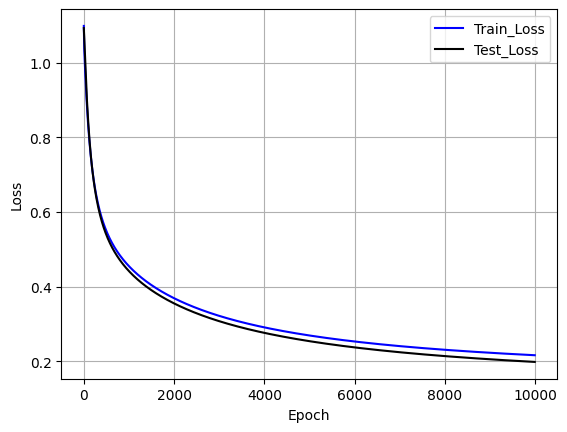

In [19]:
#학습곡선(loss)
plt.plot(history[:, 0], history[:, 1], c='b', label = 'Train_Loss')
plt.plot(history[:, 0], history[:, 3], c='k', label = 'Test_Loss')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

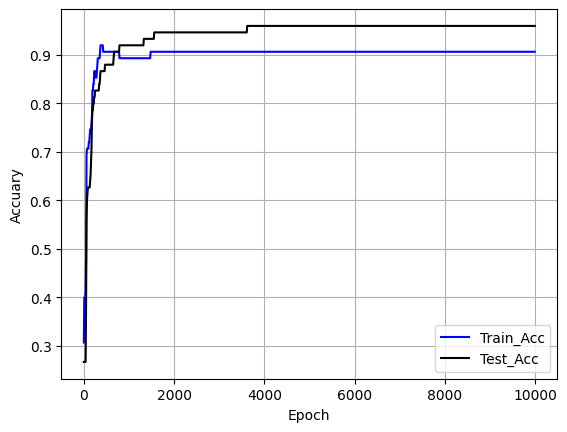

In [20]:
#학습곡선(acc)
plt.plot(history[:, 0], history[:, 2], c='b', label = 'Train_Acc')
plt.plot(history[:, 0], history[:, 4], c='k', label = 'Test_Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuary')
plt.grid()
plt.legend()
plt.show()

#### 모델 출력 확인
* 이번에는 소프트맥스 함수를 손실함수 쪽에 포함시켰으므로, 모델의 출력이 어떤 수치인지, 그리고 그 수치로부터 확률 값을 얻고 싶을 때는 어떻게 해야하는지 알아봄

In [21]:
#정답 데이터의 앞부분부터 값이 0, 1, 2인 것을 한 개씩 추출
print(labels[[0, 2, 3]])

tensor([1, 0, 2])


In [23]:
#위와 같은 인덱스로 inputs데이터도 추출
i3 = inputs[[0, 2, 3], :]
print(i3.data.numpy())

[[6.3 4.7]
 [5.  1.6]
 [6.4 5.6]]


In [24]:
#추출한 입력값 i3를 인수로 net 함수를 호출하고, 그 결과를 o3에 대입
#그리고 o3을 소프트맥스 함수에 적용한 다음, 그 결과(k3)를 표시
softmax = torch.nn.Softmax(dim=1)
o3 = net(i3)
k3 = softmax(o3)

print(o3.data.numpy()) # 선형함수의 출력 결과
print(k3.data.numpy()) #소프트맥스 함수에 적용한 결과, 확률값 형태로 나온다는 것을 확인할 수 있음
"""
모델에 입력을 통과시켜 얻은 출력으로부터 확률 값을 얻고싶은 경우,
소프트맥스 함수를 적용하면 됨
"""

[[ 8.807078   14.193761   12.998579  ]
 [12.82624     9.800001    0.17344397]
 [ 6.7954206  15.092816   17.111115  ]]
[[3.5014090e-03 7.6497865e-01 2.3151995e-01]
 [9.5374262e-01 4.6254344e-02 3.0506458e-06]
 [2.9224961e-05 1.1729165e-01 8.8267910e-01]]


In [25]:
#가중치 행렬과 바이어스 값
print(net.l1.weight.data)
print(net.l1.bias.data)

tensor([[ 3.0452, -2.5735],
        [ 1.3573,  0.8481],
        [-1.4026,  4.7253]])
tensor([ 1.7178,  1.6563, -0.3741])


#### 입력변수의 4차원화
* 입력 항목을 2번째 항목부터 4번째 항목까지 늘림
* 데이터 분할 시 데이터 x를 x_select가 아닌 x_org로 설정

In [30]:
x_select_4 = x_org
print(x_select_4.shape)

(150, 4)


In [37]:
x_train, x_test, y_train, y_test = train_test_split(x_select_4, y_org, test_size=75, random_state=123)

n_input_4 = x_train.shape[1]
n_output_4 = len(list(set(y_train)))

net = Net(n_input_4, n_output_4)

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

In [38]:
lr = 0.01

net = Net(n_input_4, n_output_4)

#최적화함수: 경사하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

#손실함수: 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

num_epoch = 10000

#평가 결과 기록
history = np.zeros((0, 5))

In [39]:
for epoch in range(num_epoch):
    ###################################### train
    optimizer.zero_grad()

    outputs = net(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    #예측 라벨 산출
    predicted = torch.max(outputs, 1)[1]

    #손실과 정확도 계산
    train_loss = loss.item()
    train_acc = (predicted == labels).sum() / len(labels)

    ##################################### predict
    outputs_test = net(inputs_test)

    loss_test = criterion(outputs_test, labels_test)

    predicted_test = torch.max(outputs_test, 1)[1]

    val_loss = loss_test.item()
    val_acc = (predicted_test == labels_test).sum() / len(labels_test)

    #기록
    if(epoch % 10 == 0):
        print(f'Epoch: [{epoch} / {num_epoch}], loss: {train_loss:.5f} acc: {train_acc:.5f}, val_loss: {val_loss:.5f}. val_acc: {val_acc:.5f}')

        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))


Epoch: [0 / 10000], loss: 1.09861 acc: 0.30667, val_loss: 1.09158. val_acc: 0.26667
Epoch: [10 / 10000], loss: 1.01848 acc: 0.40000, val_loss: 1.04171. val_acc: 0.26667
Epoch: [20 / 10000], loss: 0.96854 acc: 0.40000, val_loss: 0.98850. val_acc: 0.26667
Epoch: [30 / 10000], loss: 0.92459 acc: 0.65333, val_loss: 0.93996. val_acc: 0.57333
Epoch: [40 / 10000], loss: 0.88568 acc: 0.70667, val_loss: 0.89704. val_acc: 0.62667
Epoch: [50 / 10000], loss: 0.85120 acc: 0.70667, val_loss: 0.85918. val_acc: 0.62667
Epoch: [60 / 10000], loss: 0.82059 acc: 0.70667, val_loss: 0.82572. val_acc: 0.62667
Epoch: [70 / 10000], loss: 0.79335 acc: 0.72000, val_loss: 0.79607. val_acc: 0.62667
Epoch: [80 / 10000], loss: 0.76900 acc: 0.72000, val_loss: 0.76968. val_acc: 0.65333
Epoch: [90 / 10000], loss: 0.74717 acc: 0.72000, val_loss: 0.74610. val_acc: 0.65333
Epoch: [100 / 10000], loss: 0.72750 acc: 0.76000, val_loss: 0.72494. val_acc: 0.69333
Epoch: [110 / 10000], loss: 0.70970 acc: 0.77333, val_loss: 0.705

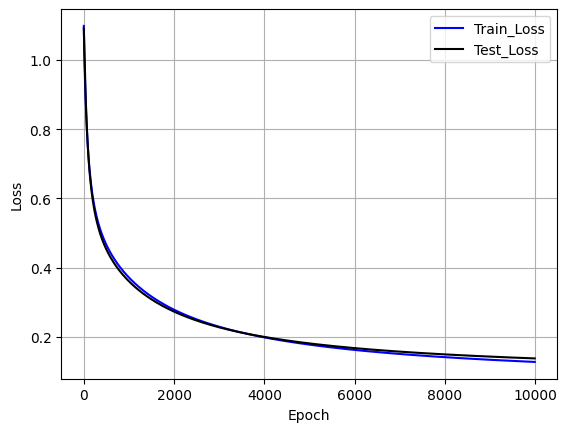

In [40]:
#학습곡선(loss)
plt.plot(history[:, 0], history[:, 1], c='b', label = 'Train_Loss')
plt.plot(history[:, 0], history[:, 3], c='k', label = 'Test_Loss')
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

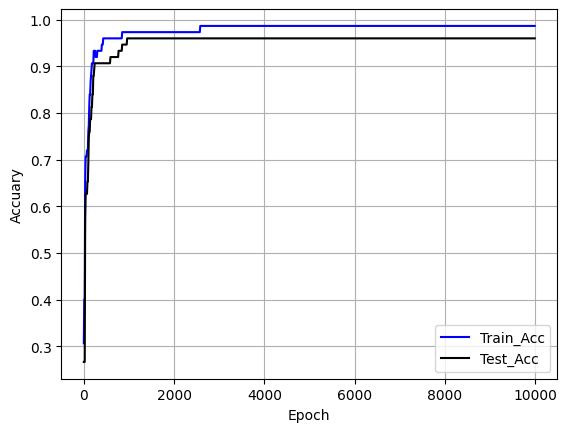

In [41]:
#학습곡선(acc)
plt.plot(history[:, 0], history[:, 2], c='b', label = 'Train_Acc')
plt.plot(history[:, 0], history[:, 4], c='k', label = 'Test_Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuary')
plt.grid()
plt.legend()
plt.show()